In [1]:
from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing
from river import forest
from river import stream
from river import ensemble
from river import tree
from river.drift import ADWIN, KSWIN, PageHinkley

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns

In [8]:
PROJECT_ROOT                     = "../"

SOURCE_DATASET_ROOT              = PROJECT_ROOT + "datasets/isp3/"

SOURCE_DATASET_FILENAME          = SOURCE_DATASET_ROOT + "[dvwa.isp_xvwa.isp]_https_apache.csv"
SOURCE_DATASET_FILENAME_D        = SOURCE_DATASET_ROOT + "[dvwa.isp]_https_apache.csv"
SOURCE_DATASET_FILENAME_X        = SOURCE_DATASET_ROOT + "[xvwa.isp]_https_apache.csv"
# SOURCE_DATASET_TRAIN_FILENAME    = SOURCE_DATASET_ROOT + "DataSetN_Train.csv"
# SOURCE_DATASET_TEST_FILENAME     = SOURCE_DATASET_ROOT + "DataSetN_Test.csv"

# Фичи

In [9]:
df = pd.read_csv(SOURCE_DATASET_FILENAME)
df['Label'].value_counts()

/tmp/ipykernel_779734/3322869287.py:1: DtypeWarning: Columns (3,103,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SOURCE_DATASET_FILENAME)


Label
Web Attack - DDoS                 65295
Benign                             4446
Web Attack - XSS                   2686
Web Attack - SQL Injection         1483
Web Attack - Command Injection     1400
Web Attack - Brute Force            497
Web Attack - Web Shell              353
Web Attack - CSRF                    60
Name: count, dtype: int64

In [10]:
excluded = ['Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol', 'Timestamp', "Unnamed: 0", "xvwa.isp", "Label", "dvwa.isp"]
df = df.drop(columns=excluded, errors='ignore')

In [11]:
excluded2 = ['Session_Index',  'Target','Http_Reqest','Root','GlobalLabel','Type','Tools','ToolsThreads','ToolsDelay','ToolsAdditional',
             'ChannelSpeedBefore','ChannelSpeedAfter','NetemString','Server','KeepAliveTimeout','TargetProtocol','File','SessionAnalizerMode']
df = df.drop(columns=excluded2)

In [12]:
webattack_features = list(df.columns)
webattack_features = ['Flow_Duration',
 'Total_Fwd_Packets',
 'Fwd_Packet_Length_Max',
 'Bwd_Packet_Length_Max',
 'Flow_Bytes_s',
 'Flow_Packets_s',
 'Flow_IAT_Min',
 'Fwd_IAT_Min',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Min',
 'Packet_Length_Variance',
 'Fwd_FIN_Flags',
 'Fwd_SYN_Flags',
 'Fwd_RST_Flags',
 'Bwd_FIN_Flags',
 'Stream_Session_Number',
 'Stream_Was_Prev_Session',
 'Stream_Was_Next_Session',
 'Stream_Session_Intervals_Min_Duration',
 'Stream_Session_Intervals_Std_Duration',
 'Stream_Session_Durations_Min_Duration',
 'Stream_Session_Durations_Max_Duration',
 'Fwd_Bandwidth_Max',
 'Bwd_Bandwidth_Min',
 'Bwd_Bandwidth_Max']

# Выбор гиперпараметров

In [13]:
best_params_ = {
    'max_depth': 17,
    'max_features': 10,
    # 'min_samples_leaf': 3,
    'n_models': 50
}

# Подготовка датасета

In [14]:
def prepare_dataset(name, train_size=0.2, test_size=0.8):
    df = pd.read_csv(name)
    df['Label'].value_counts()

    label_rows = df[df['Label'] == 'Web Attack - DDoS']
    rows_to_remove = label_rows.sample(frac=0.94, random_state=42)
    df = df.drop(index=rows_to_remove.index)
    df['Label'].value_counts()
    
    attacks = {
        'Web Attack - XSS',
        'Web Attack - CSRF',
        'Web Attack - Brute Force',
        'Web Attack - Web Shell',
        'Web Attack - Command Injection',
        'Web Attack - SQL Injection',
        'Web Attack - DDoS'
    }
    attack_to_exclude = {}
    benign = {'Benign', 'FromInSide'}

    df['Label'] = df['Label'].replace(to_replace=benign, value='Benign')
    df['Label'].value_counts()

    df_full = df[df['Label'].isin(attacks | benign)].copy()
    df_full['Label'].value_counts()
    
    # df_full = df_full.groupby('Label').apply(lambda x: x.sample(n=6000, replace=True)).reset_index(drop=True)

    X = df_full[webattack_features]
    y = df_full['Label']
    if train_size == 0 and test_size == 1:
        return [], X, [], y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, 
                                                            train_size=train_size, test_size=test_size, shuffle=True, random_state=0)
    return X_train, X_test, y_train, y_test

In [15]:
_, X_test_dt, _, y_test_dt = prepare_dataset(SOURCE_DATASET_FILENAME_D, train_size=0, test_size=1)
_, X_test_xt, _, y_test_xt = prepare_dataset(SOURCE_DATASET_FILENAME_X, train_size=0, test_size=1)
X_test_d1, X_test_d2, y_test_d1, y_test_d2 = train_test_split(X_test_dt, y_test_dt, stratify=y_test_dt, 
                                                        train_size=0.5, test_size=0.5, shuffle=True, random_state=0)
X_test_x1, X_test_x2, y_test_x1, y_test_x2 = train_test_split(X_test_xt, y_test_xt, stratify=y_test_xt, 
                                                        train_size=0.3, test_size=0.7, shuffle=True, random_state=0)

/tmp/ipykernel_779734/1871289745.py:2: DtypeWarning: Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name)
/tmp/ipykernel_779734/1871289745.py:2: DtypeWarning: Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name)


In [16]:
# X_train = pd.concat([X_train_d, X_train_x])
# y_train = pd.concat([y_train_d, y_train_x])
# X_test1 = pd.concat([X_test_d1, X_test_x1])
# y_test1 = pd.concat([y_test_d1, y_test_x1])
# X_test2 = pd.concat([X_test_d2, X_test_x2])
# y_test2 = pd.concat([y_test_d2, y_test_x2])

In [17]:
X_train = X_test_d1
y_train = y_test_d1
X_test1 = pd.concat([X_test_d2, X_test_x1])
y_test1 = pd.concat([y_test_d2, y_test_x1])
X_test2 = X_test_x2
y_test2 = y_test_x2

In [18]:
point = len(y_test_d2)
point1 = point + len(y_test_x1)
point2 = point1 + len(X_test_x2)
print(point, point1, point2)

3380 5804 11462


# Обучение

In [19]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name, dr=[]):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg F1-score: %.2f%%'%(m[-1]))
    m_min = np.array(m).min()

    for i in range(len(dr)):
        if i!=0:
            # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
            plt.vlines(dr[i], m_min, 100, colors = "red", linewidth=4, linestyles = "dashed")

    plt.legend(loc='best')
    plt.title(name+' on [dvwa.isp_xvwa.isp]_https_apache', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('F1 (%)')

    plt.draw()

In [20]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test1, y_test1, X_test2, y_test2, l=True):
    metric = metrics.MicroF1() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
        model.learn_one(xi1,yi1)

    for xi, yi in tqdm(stream.iter_pandas(X_test1, y_test1), total=y_test1.shape[0]):
        y_pred= model.predict_one(xi)  # Predict the test sample
        metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    
    # Predict the test set
    for xi, yi in tqdm(stream.iter_pandas(X_test2, y_test2), total=y_test2.shape[0]):
        y_pred= model.predict_one(xi)  # Predict the test sample
        if l:
            model.learn_one(xi,yi) # Learn the test sample
        metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
    return t, m

In [21]:
%%time
# Use the Adaptive Random Forest (ARF) model without drift detector
name10 = "ARF model"
model10 = forest.ARFClassifier(n_models = 10, drift_detector = None, seed=2024) # Define the model
t, m10 = adaptive_learning(model10, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 89.42%
Precision: 90.14%
Recall: 89.42%
F1-score: 88.6%
CPU times: user 20.1 s, sys: 578 ms, total: 20.7 s
Wall time: 20.6 s


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN model"
model1 = forest.ARFClassifier(n_models = 10, drift_detector = ADWIN(delta=1.1061379919896652e-05), seed=2024) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 93.23%
Precision: 93.57%
Recall: 93.23%
F1-score: 92.9%
CPU times: user 21.4 s, sys: 631 ms, total: 22 s
Wall time: 21.9 s


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
%%time
# Use the Adaptive Random Forest (ARF) model with DDM drift detector
name2 = "ARF-KSWIN model"
model2 = forest.ARFClassifier(n_models = 10, drift_detector = KSWIN(), seed=2024) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 93.31%
Precision: 93.72%
Recall: 93.31%
F1-score: 92.97999999999999%
CPU times: user 1min 5s, sys: 920 ms, total: 1min 6s
Wall time: 1min 6s


In [24]:
%%time
# Use the Adaptive Random Forest (ARF) model with DDM drift detector
name3 = "ARF-PageHinkley model"
model3 = forest.ARFClassifier(n_models = 8, drift_detector = PageHinkley(delta=0.09840272830999897, threshold=59.820920335220336), seed=2024) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 92.53%
Precision: 92.71000000000001%
Recall: 92.53%
F1-score: 92.14%
CPU times: user 19.6 s, sys: 493 ms, total: 20.1 s
Wall time: 20 s


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
%%time
# Use the Streaming Random Patches (SRP) model without drift detector
name40 = "SRP model"
model40 = ensemble.SRPClassifier(n_models = 8, drift_detector = None, seed=2024) # Define the model
t, m40 = adaptive_learning(model40, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 85.81%
Precision: 87.13%
Recall: 85.81%
F1-score: 84.68%
CPU times: user 1min 53s, sys: 1.17 s, total: 1min 54s
Wall time: 1min 53s


In [26]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name4 = "SRP-ADWIN model"
model4 = ensemble.SRPClassifier(n_models = 9, drift_detector = ADWIN(delta=0.002845576739774139), seed=2024) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 85.26%
Precision: 86.19%
Recall: 85.26%
F1-score: 84.09%
CPU times: user 2min 50s, sys: 1.95 s, total: 2min 52s
Wall time: 2min 51s


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
%%time
# Use the Streaming Random Patches (SRP) model with DDM drift detector
name5 = "SRP-KSWIN model"
model5 = ensemble.SRPClassifier(n_models = 8, drift_detector = KSWIN(), seed=2024) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 91.67999999999999%
Precision: 91.75%
Recall: 91.67999999999999%
F1-score: 91.09%
CPU times: user 4min 10s, sys: 3.16 s, total: 4min 13s
Wall time: 4min 12s


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
%%time
# Use the Streaming Random Patches (SRP) model with DDM drift detector
name6 = "SRP-PageHinkley model"
model6 = ensemble.SRPClassifier(n_models = 8, drift_detector = PageHinkley(delta=0.09840272830999897, threshold=59.820920335220336), seed=2024) # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 89.98%
Precision: 90.49000000000001%


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 89.98%
F1-score: 89.39%
CPU times: user 2min 48s, sys: 1.9 s, total: 2min 49s
Wall time: 2min 49s


In [29]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model 
name7 = "EFDT model"
model7 = tree.ExtremelyFastDecisionTreeClassifier() # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 82.42%
Precision: 82.33%
Recall: 82.42%
F1-score: 81.12%
CPU times: user 1min 55s, sys: 795 ms, total: 1min 56s
Wall time: 1min 55s


In [30]:
%%time
# Use the Hoeffding Tree (HT) model 
name8 = "HT model"
model8 = tree.HoeffdingTreeClassifier() # Define the model
t, m8 = adaptive_learning(model8, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 67.14%
Precision: 75.64999999999999%
Recall: 67.14%
F1-score: 67.93%
CPU times: user 6.75 s, sys: 44.2 ms, total: 6.8 s
Wall time: 6.75 s


In [31]:
%%time
# Use the Leveraging Bagging (LB) model 
name9 = "LB model"
model9 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m9 = adaptive_learning(model9, X_train, y_train, X_test1, y_test1, X_test2, y_test2) # Learn the model on the dataset

  0%|          | 0/3380 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 83.41%
Precision: 84.45%
Recall: 83.41%
F1-score: 83.23%
CPU times: user 1min 10s, sys: 546 ms, total: 1min 11s
Wall time: 1min 10s


In [43]:
# Define the online LightGBM model
def lightGBM_learning(X_train, y_train, X_test, y_test):
    metric = metrics.MicroF1()
    i = 0
    t = []
    m = []
    yt = []
    yp = []

    model = lgb.LGBMClassifier(verbose = -1)
    model.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        xi2=np.array(list(xi.values()))
        y_pred = model.predict(xi2.reshape(1, -1))      # make a prediction
        y_pred = y_pred[0]
        metric.update(yi, y_pred)  # update the metric
        
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
    return t, m

In [44]:
%%time
# Use the online LightGBM model
name0 = "LightGBM model"
t, m0 = lightGBM_learning(X_train, y_train, X_test1, y_test1) # Learn the LightGBM model on the dataset

Accuracy: 95.19%
Precision: 95.38%
Recall: 95.19%
F1-score: 95.00999999999999%
CPU times: user 35.2 s, sys: 132 ms, total: 35.4 s
Wall time: 4.58 s


In [34]:
class PWPAE:
    def __init__(self):
        self.ws = [0,0,0,0]
        self.ep = 0.001
        
        self.hat1 = forest.ARFClassifier(n_models = 10, drift_detector = ADWIN(delta=1.1061379919896652e-05), seed=2024)  # ARF-KSWIN
        self.hat2 = forest.ARFClassifier(n_models = 10, drift_detector = KSWIN(), seed=2024) # ARF-PageHinkley
        self.hat3 = ensemble.SRPClassifier(n_models = 8, drift_detector = ADWIN(delta=1.1061379919896652e-05), seed=2024)  # ARF
        self.hat4 = ensemble.SRPClassifier(n_models = 8, drift_detector = KSWIN(), seed=2024) # SRP-KSWIN

        self.metric = metrics.MicroF1()
        self.metric1 = metrics.MicroF1()
        self.metric2 = metrics.MicroF1()
        self.metric3 = metrics.MicroF1()
        self.metric4 = metrics.MicroF1()
    
    def fit(self, X_train, y_train):
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, stratify=y_train, 
                                                        train_size=0.5, test_size=0.5, shuffle=True, random_state=2024)
        for xi1, yi1 in tqdm(stream.iter_pandas(X_train1, y_train1), total=y_train1.shape[0]):
            self.hat1.learn_one(xi1,yi1)
            self.hat2.learn_one(xi1,yi1)
            self.hat3.learn_one(xi1,yi1)
            self.hat4.learn_one(xi1,yi1)

        i=0
        t = []
        m = []
        yt = []
        yp = []
        dr = []
        dr_c = 0
        
        for xi, yi in tqdm(stream.iter_pandas(X_train2, y_train2), total=y_train2.shape[0]):
            # The four base learner predict the labels
            y_pred1= self.hat1.predict_one(xi) 
            y_prob1= self.hat1.predict_proba_one(xi) 

            y_pred2= self.hat2.predict_one(xi) 
            y_prob2= self.hat2.predict_proba_one(xi)

            y_pred3= self.hat3.predict_one(xi) 
            y_prob3= self.hat3.predict_proba_one(xi)

            y_pred4= self.hat4.predict_one(xi) 
            y_prob4= self.hat4.predict_proba_one(xi)

            
            # Record their real-time accuracy
            self.metric1.update(yi, y_pred1)
            self.metric2.update(yi, y_pred2)
            self.metric3.update(yi, y_pred3)
            self.metric4.update(yi, y_pred4)    

            # Calculate the real-time error rates of four base learners
            e1 = 1-self.metric1.get()
            e2 = 1-self.metric2.get()
            e3 = 1-self.metric3.get()
            e4 = 1-self.metric4.get()
            
            # Calculate the weight of each base learner by the reciprocal of its real-time error rate
            ea = 1/(e1+self.ep)+1/(e2+self.ep)+1/(e3+self.ep)+1/(e4+self.ep)
            self.ws[0] = 1/(e1+self.ep)/ea
            self.ws[1] = 1/(e2+self.ep)/ea
            self.ws[2] = 1/(e3+self.ep)/ea
            self.ws[3] = 1/(e4+self.ep)/ea

            # Make ensemble predictions by the classification probabilities
            y_prob_all = (self.ws[0]*pd.Series(y_prob1) + self.ws[1]*pd.Series(y_prob2) + self.ws[2]*pd.Series(y_prob3) + self.ws[3]*pd.Series(y_prob4))/4
            y_pred_all = y_prob_all.idxmax()
            self.hat1.learn_one(xi,yi)
            self.hat2.learn_one(xi,yi)
            self.hat3.learn_one(xi,yi)
            self.hat4.learn_one(xi,yi)

            if dr_c < self.hat1.n_drifts_detected():
                dr_c = self.hat1.n_drifts_detected()
                dr.append(i)
            
            # Update the real-time accuracy of the ensemble model
            self.metric.update(yi, y_pred_all)

            t.append(i)
            m.append(self.metric.get()*100)
            yt.append(yi)
            yp.append(y_pred_all)
            
            i=i+1

        
    
    def partial_fit(self, X_train, y_train):
        
        i=0
        t = []
        m = []
        yt = []
        yp = []
        dr = []
        dr_c = 0
        
        for xi, yi in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            # The four base learner predict the labels
            y_pred1= self.hat1.predict_one(xi) 
            y_prob1= self.hat1.predict_proba_one(xi) 

            y_pred2= self.hat2.predict_one(xi) 
            y_prob2= self.hat2.predict_proba_one(xi)

            y_pred3= self.hat3.predict_one(xi) 
            y_prob3= self.hat3.predict_proba_one(xi)

            y_pred4= self.hat4.predict_one(xi) 
            y_prob4= self.hat4.predict_proba_one(xi)

            
            # Record their real-time accuracy
            self.metric1.update(yi, y_pred1)
            self.metric2.update(yi, y_pred2)
            self.metric3.update(yi, y_pred3)
            self.metric4.update(yi, y_pred4)    

            # Calculate the real-time error rates of four base learners
            e1 = 1-self.metric1.get()
            e2 = 1-self.metric2.get()
            e3 = 1-self.metric3.get()
            e4 = 1-self.metric4.get()
            
            # Calculate the weight of each base learner by the reciprocal of its real-time error rate
            ea = 1/(e1+self.ep)+1/(e2+self.ep)+1/(e3+self.ep)+1/(e4+self.ep)
            self.ws[0] = 1/(e1+self.ep)/ea
            self.ws[1] = 1/(e2+self.ep)/ea
            self.ws[2] = 1/(e3+self.ep)/ea
            self.ws[3] = 1/(e4+self.ep)/ea

            # Make ensemble predictions by the classification probabilities
            y_prob_all = (self.ws[0]*pd.Series(y_prob1) + self.ws[1]*pd.Series(y_prob2) + self.ws[2]*pd.Series(y_prob3) + self.ws[3]*pd.Series(y_prob4))/4
            y_pred_all = y_prob_all.idxmax()
            self.hat1.learn_one(xi,yi)
            self.hat2.learn_one(xi,yi)
            self.hat3.learn_one(xi,yi)
            self.hat4.learn_one(xi,yi)

            if dr_c < self.hat1.n_drifts_detected():
                dr_c = self.hat1.n_drifts_detected()
                dr.append(i)
            
            # Update the real-time accuracy of the ensemble model
            self.metric.update(yi, y_pred_all)

            t.append(i)
            m.append(self.metric.get()*100)
            yt.append(yi)
            yp.append(y_pred_all)
            
            i=i+1
            
        print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
        print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
        print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
        print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
        return t, m, dr
    
    def predict_test(self, X_train, y_train):
        
        i=0
        t = []
        m = []
        yt = []
        yp = []
        dr = []
        dr_c = 0
        
        for xi, yi in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            y_prob1= self.hat1.predict_proba_one(xi) 
            y_prob2= self.hat2.predict_proba_one(xi)
            y_prob3= self.hat3.predict_proba_one(xi)
            y_prob4= self.hat4.predict_proba_one(xi)

            # Make ensemble predictions by the classification probabilities
            y_prob_all = (self.ws[0]*pd.Series(y_prob1) + self.ws[1]*pd.Series(y_prob2) + self.ws[2]*pd.Series(y_prob3) + self.ws[3]*pd.Series(y_prob4))/4
            y_pred_all = y_prob_all.idxmax()
            
            if dr_c < self.hat1.n_drifts_detected():
                dr_c = self.hat1.n_drifts_detected()
                dr.append(i)

            # Update the real-time accuracy of the ensemble model
            self.metric.update(yi, y_pred_all)

            t.append(i)
            m.append(self.metric.get()*100)
            yt.append(yi)
            yp.append(y_pred_all)
            
            i=i+1
        print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
        print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
        print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
        print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
        return t, m

In [35]:
pwpae = PWPAE()

  0%|          | 0/1690 [00:00<?, ?it/s]

  0%|          | 0/1690 [00:00<?, ?it/s]

  0%|          | 0/5804 [00:00<?, ?it/s]

Accuracy: 93.71000000000001%
Precision: 93.78999999999999%
Recall: 93.71000000000001%
F1-score: 93.34%


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/5658 [00:00<?, ?it/s]

Accuracy: 97.03%
Precision: 96.82%
Recall: 97.03%
F1-score: 96.85000000000001%
CPU times: user 9min 22s, sys: 7.19 s, total: 9min 29s
Wall time: 9min 26s


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


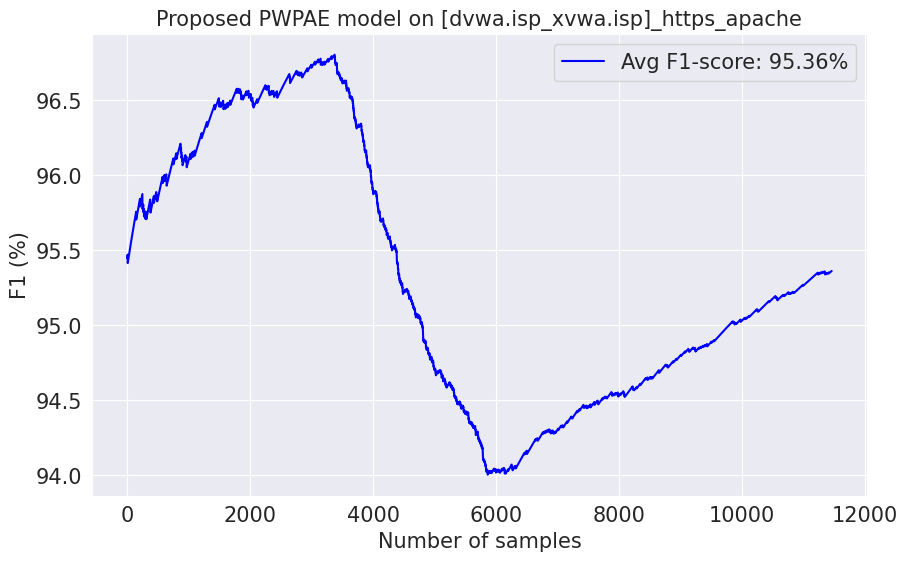

In [36]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "Proposed PWPAE model"
pwpae.fit(X_train, y_train)
t1, m_t1 = pwpae.predict_test(X_test1, y_test1)
t2, m_t2, dr = pwpae.partial_fit(X_test2, y_test2) # Learn the model on the dataset
m = m_t1 + m_t2
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

In [37]:
dr = np.array(dr)+point1

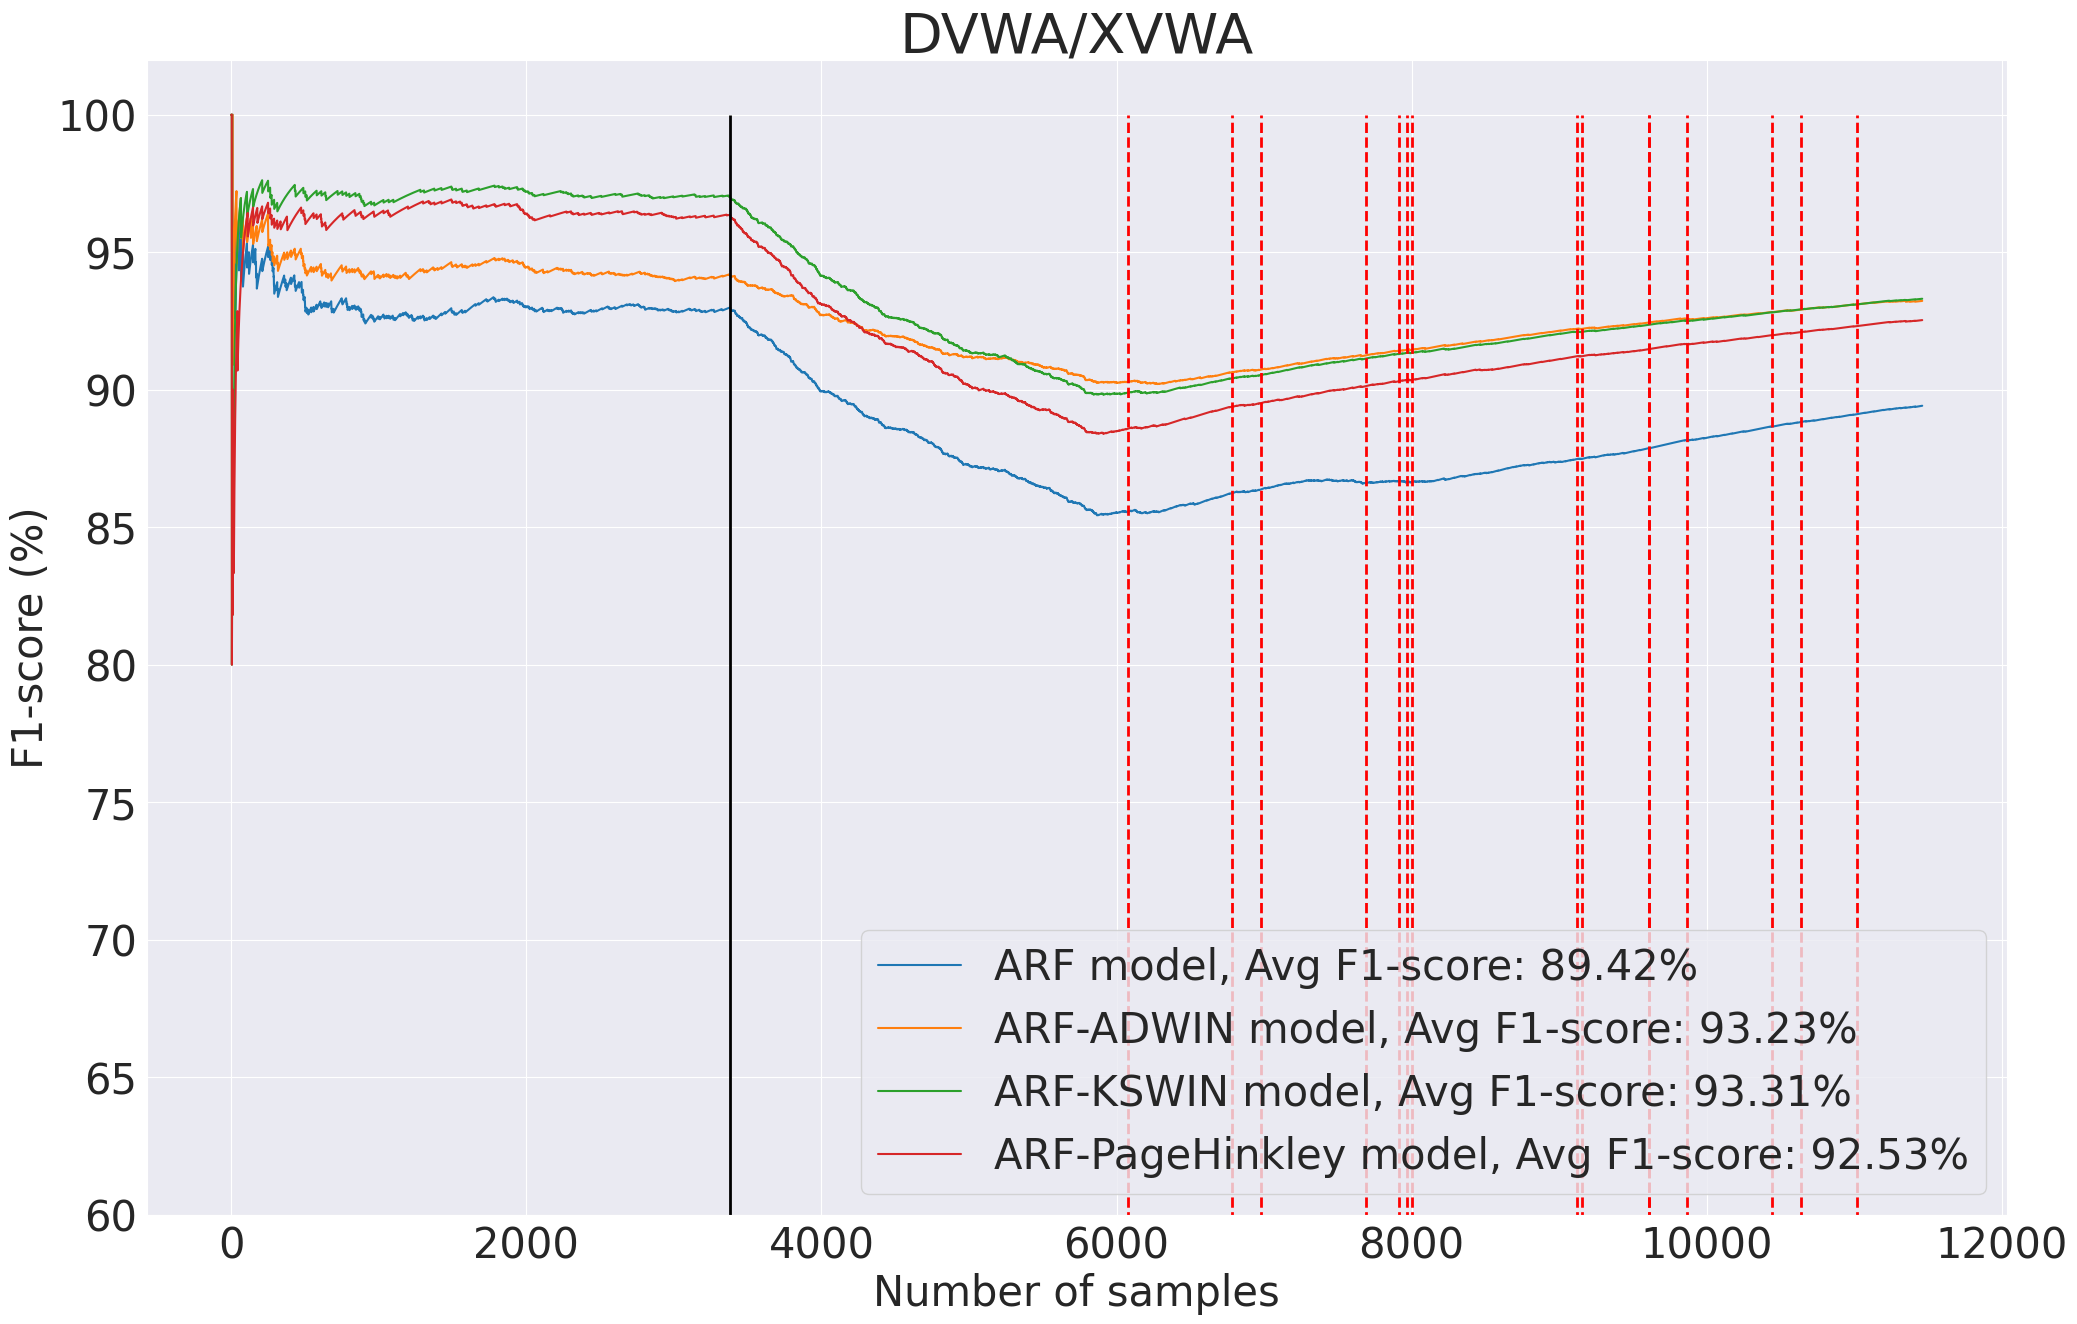

In [39]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m10,label=name10+', Avg F1-score: %.2f%%'%(m10[-1]))
plt.plot(t,m1,label=name1+', Avg F1-score: %.2f%%'%(m1[-1]))
plt.plot(t,m2,label=name2+', Avg F1-score: %.2f%%'%(m2[-1]))
plt.plot(t,m3,label=name3+', Avg F1-score: %.2f%%'%(m3[-1]))

# Draw the drift points/time
# dr = [0,9900,12600, 14200,15800,18800,21600]
for i in range(len(dr)):
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=2, linestyles = "dashed")

plt.vlines(point, 0, 100, colors="black", linewidth=2)
        
plt.legend(loc='lower right')
plt.ylim(60, 102)
plt.title('DVWA/XVWA', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('F1-score (%)')

plt.draw()

Text(0, 0.5, 'F1-score (%)')

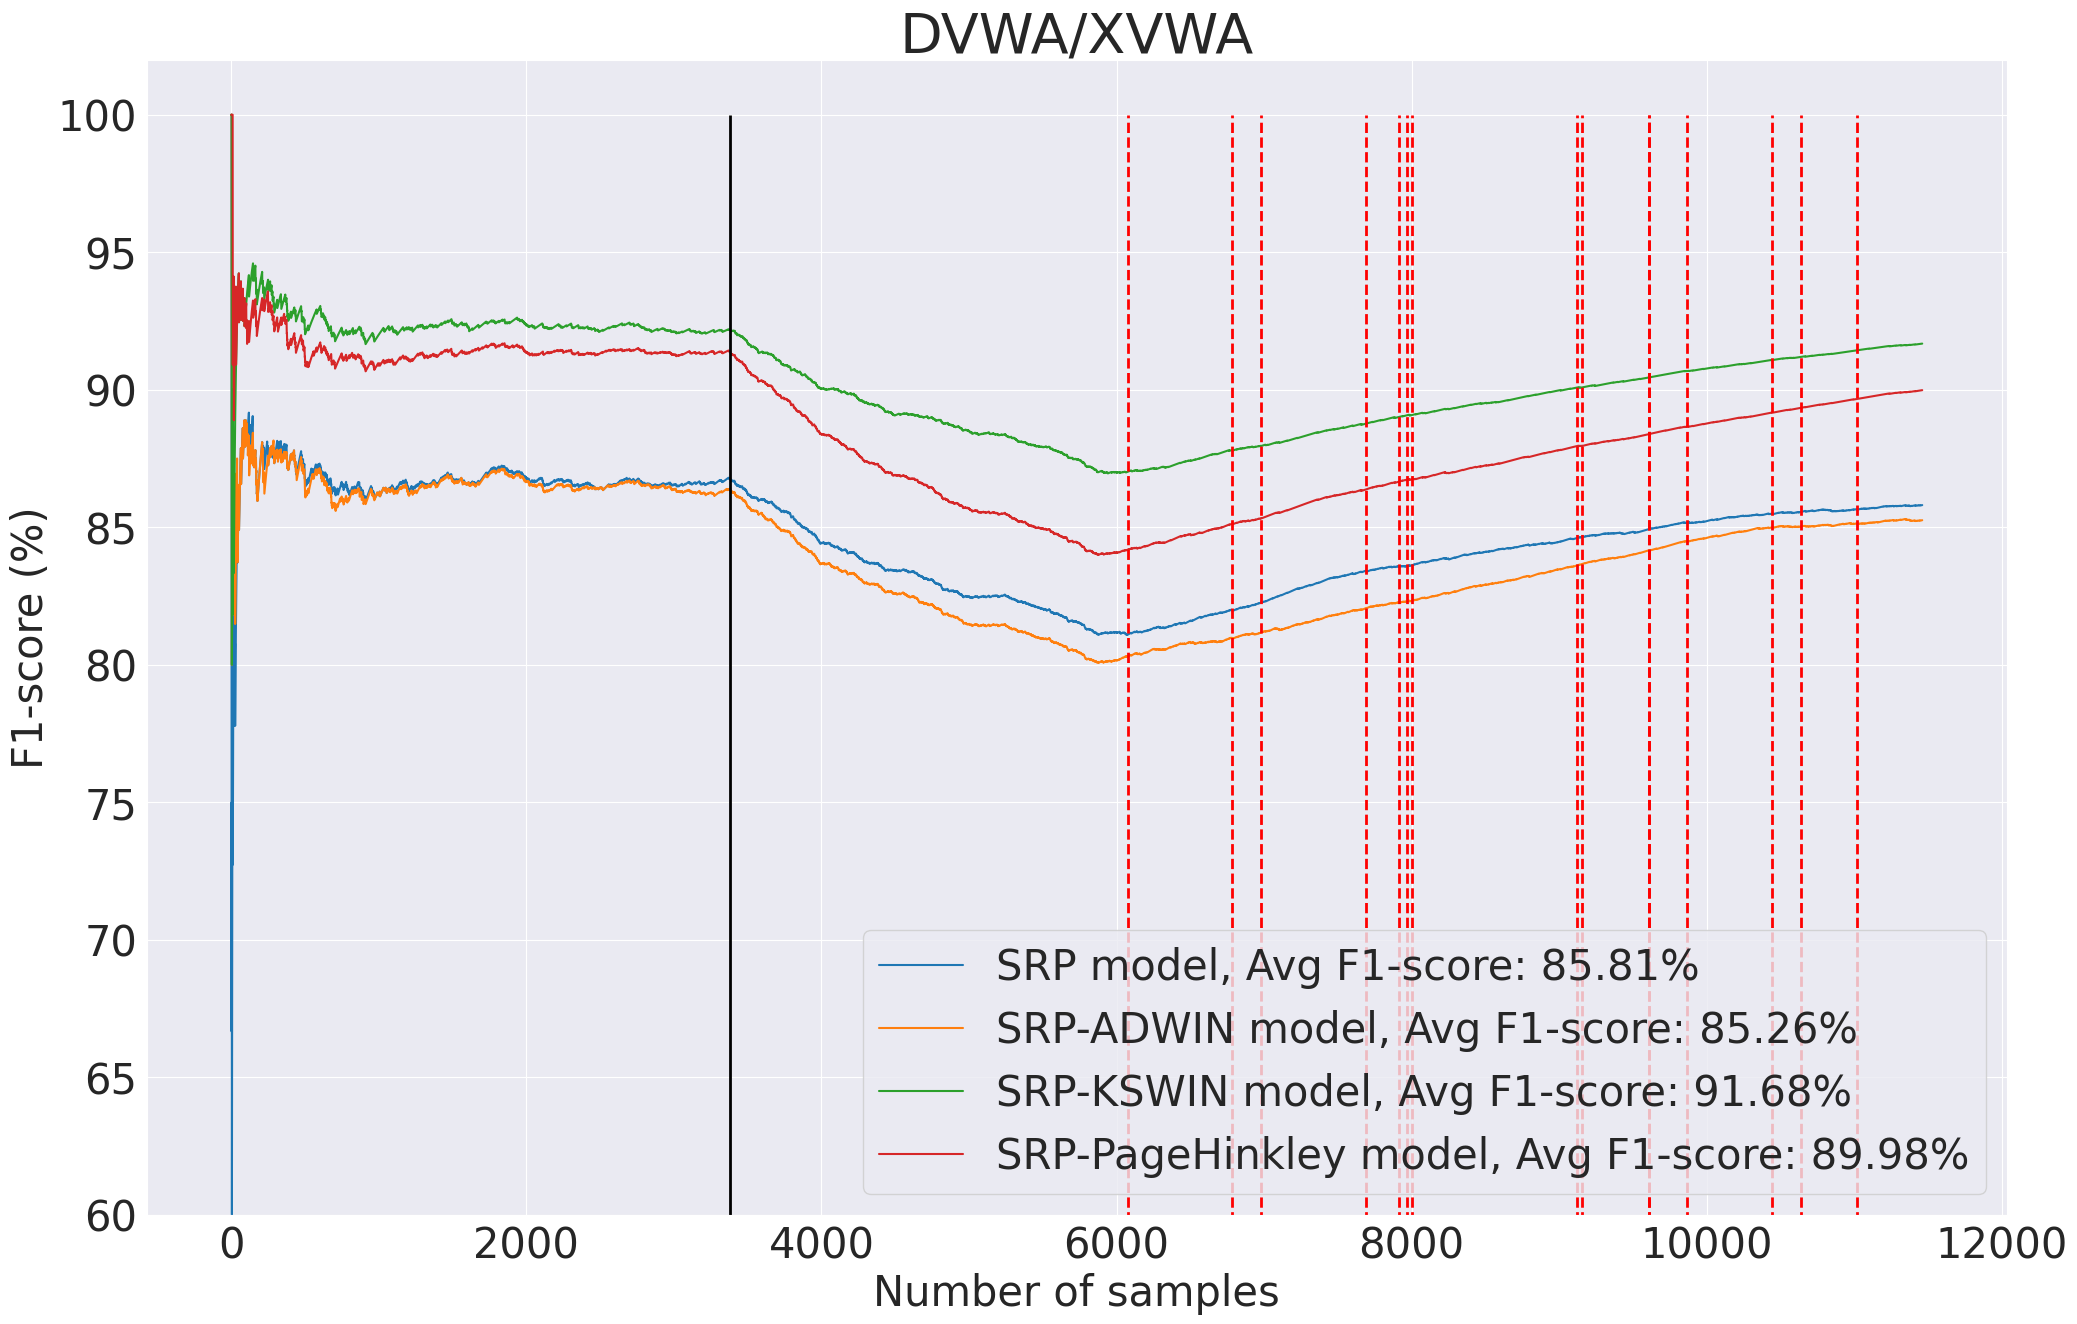

In [40]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf()

plt.plot(t,m40,label=name40+', Avg F1-score: %.2f%%'%(m40[-1]))
plt.plot(t,m4,label=name4+', Avg F1-score: %.2f%%'%(m4[-1]))
plt.plot(t,m5,label=name5+', Avg F1-score: %.2f%%'%(m5[-1]))
plt.plot(t,m6,label=name6+', Avg F1-score: %.2f%%'%(m6[-1]))

# Draw the drift points/time
for i in range(len(dr)):
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=2, linestyles = "dashed")

plt.vlines(point, 0, 100, colors="black", linewidth=2)
        
plt.legend(loc='lower right')
plt.ylim(60, 102)
plt.title('DVWA/XVWA', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('F1-score (%)')

Text(0, 0.5, 'F1-score (%)')

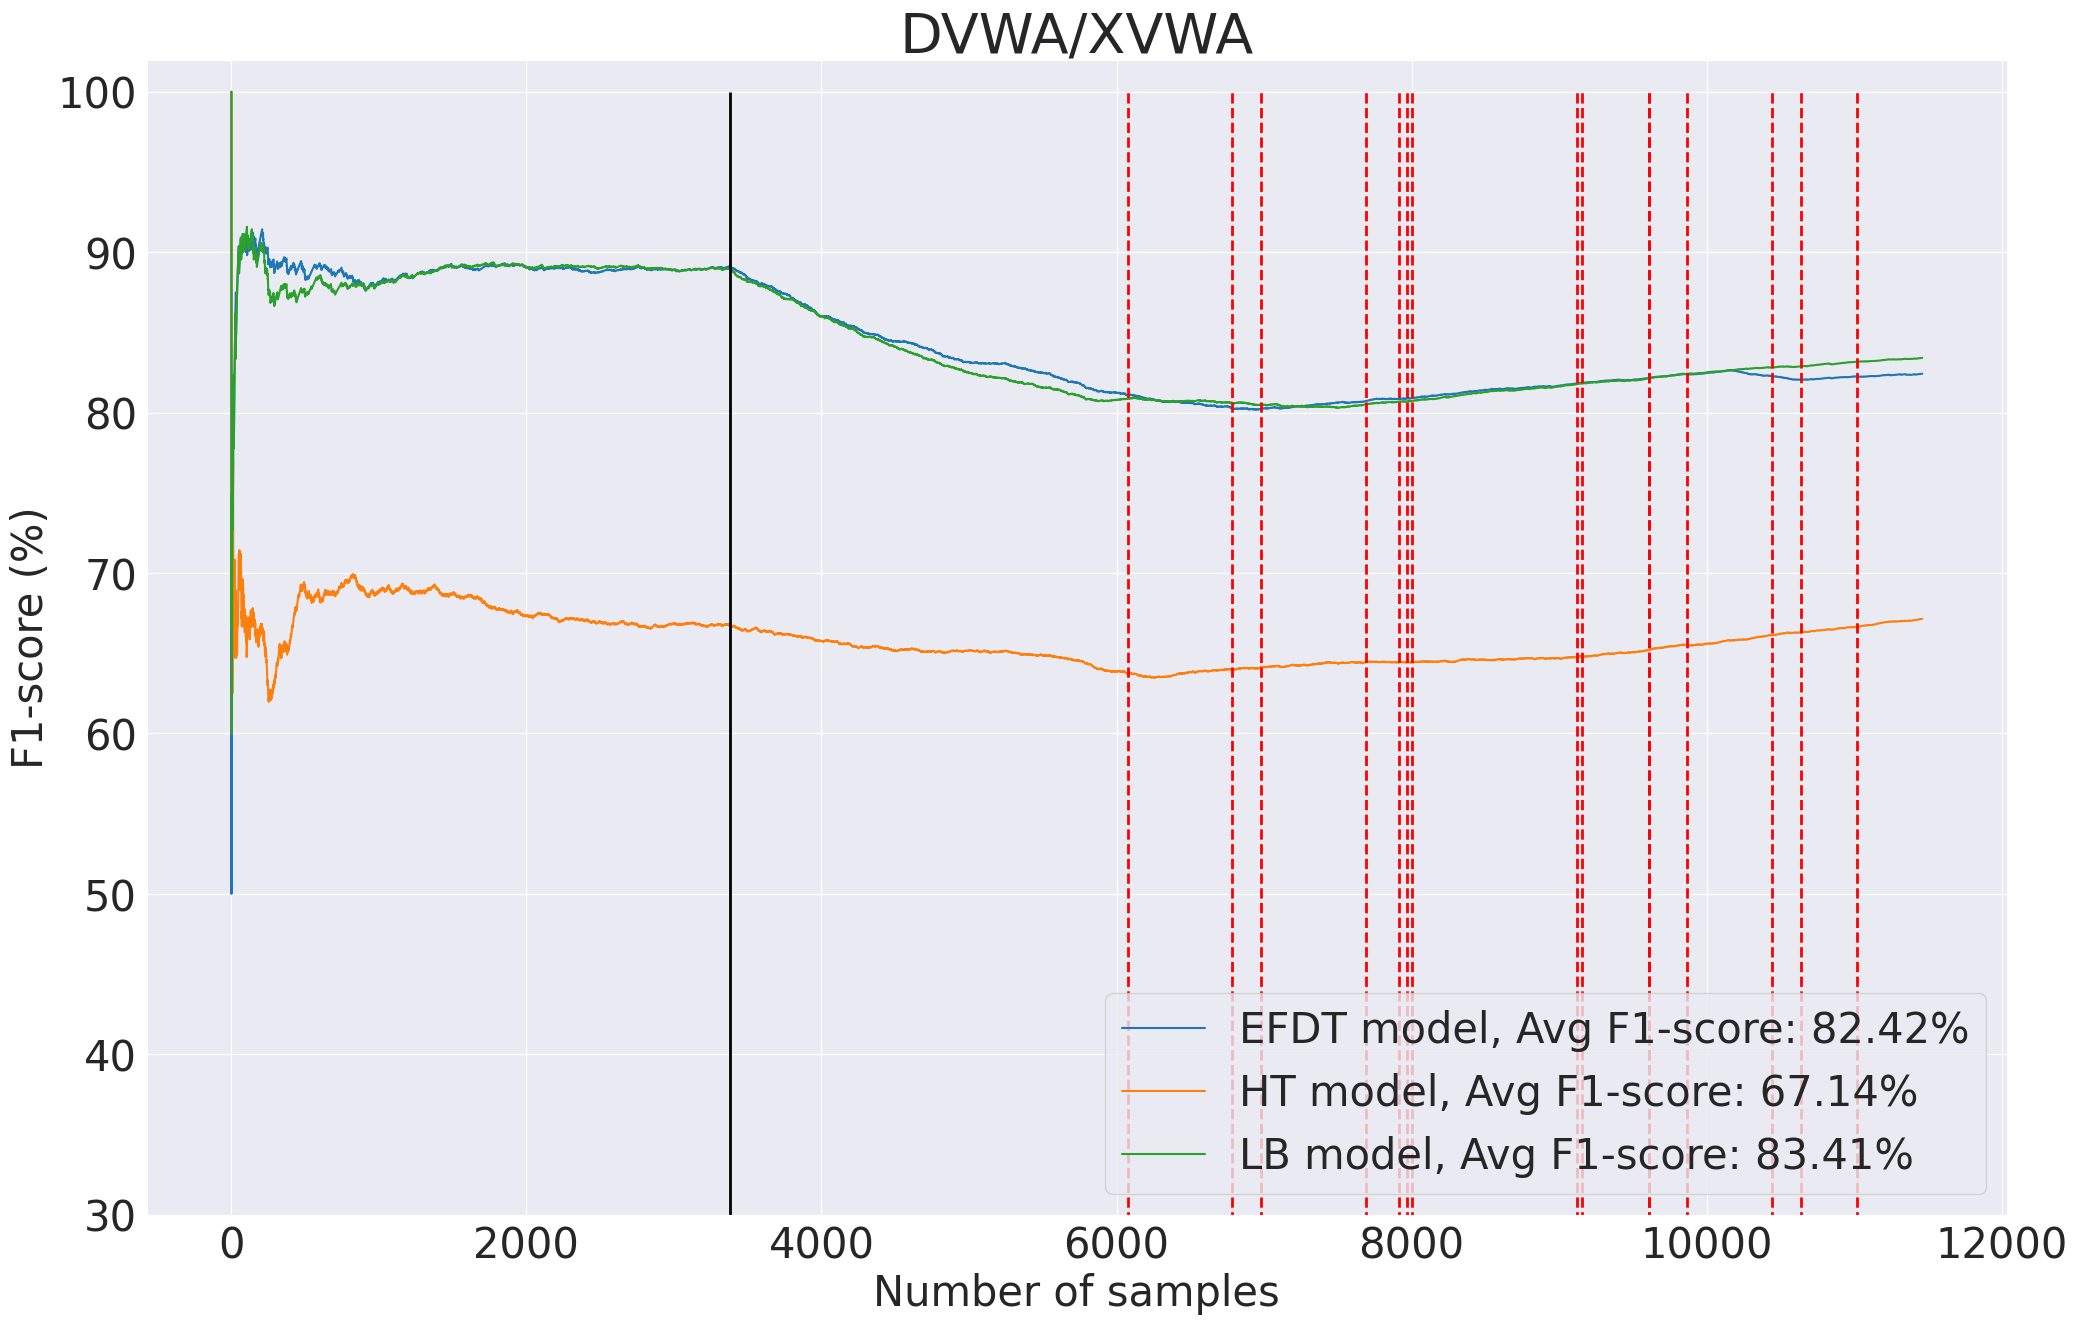

In [41]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

plt.plot(t,m7,label=name7+', Avg F1-score: %.2f%%'%(m7[-1]))
plt.plot(t,m8,label=name8+', Avg F1-score: %.2f%%'%(m8[-1]))
plt.plot(t,m9,label=name9+', Avg F1-score: %.2f%%'%(m9[-1]))

# Draw the drift points/time
for i in range(len(dr)):
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=2, linestyles = "dashed")

plt.vlines(point, 0, 100, colors="black", linewidth=2)
        
plt.legend(loc='lower right')
plt.ylim(30, 102)
plt.title('DVWA/XVWA', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('F1-score (%)')

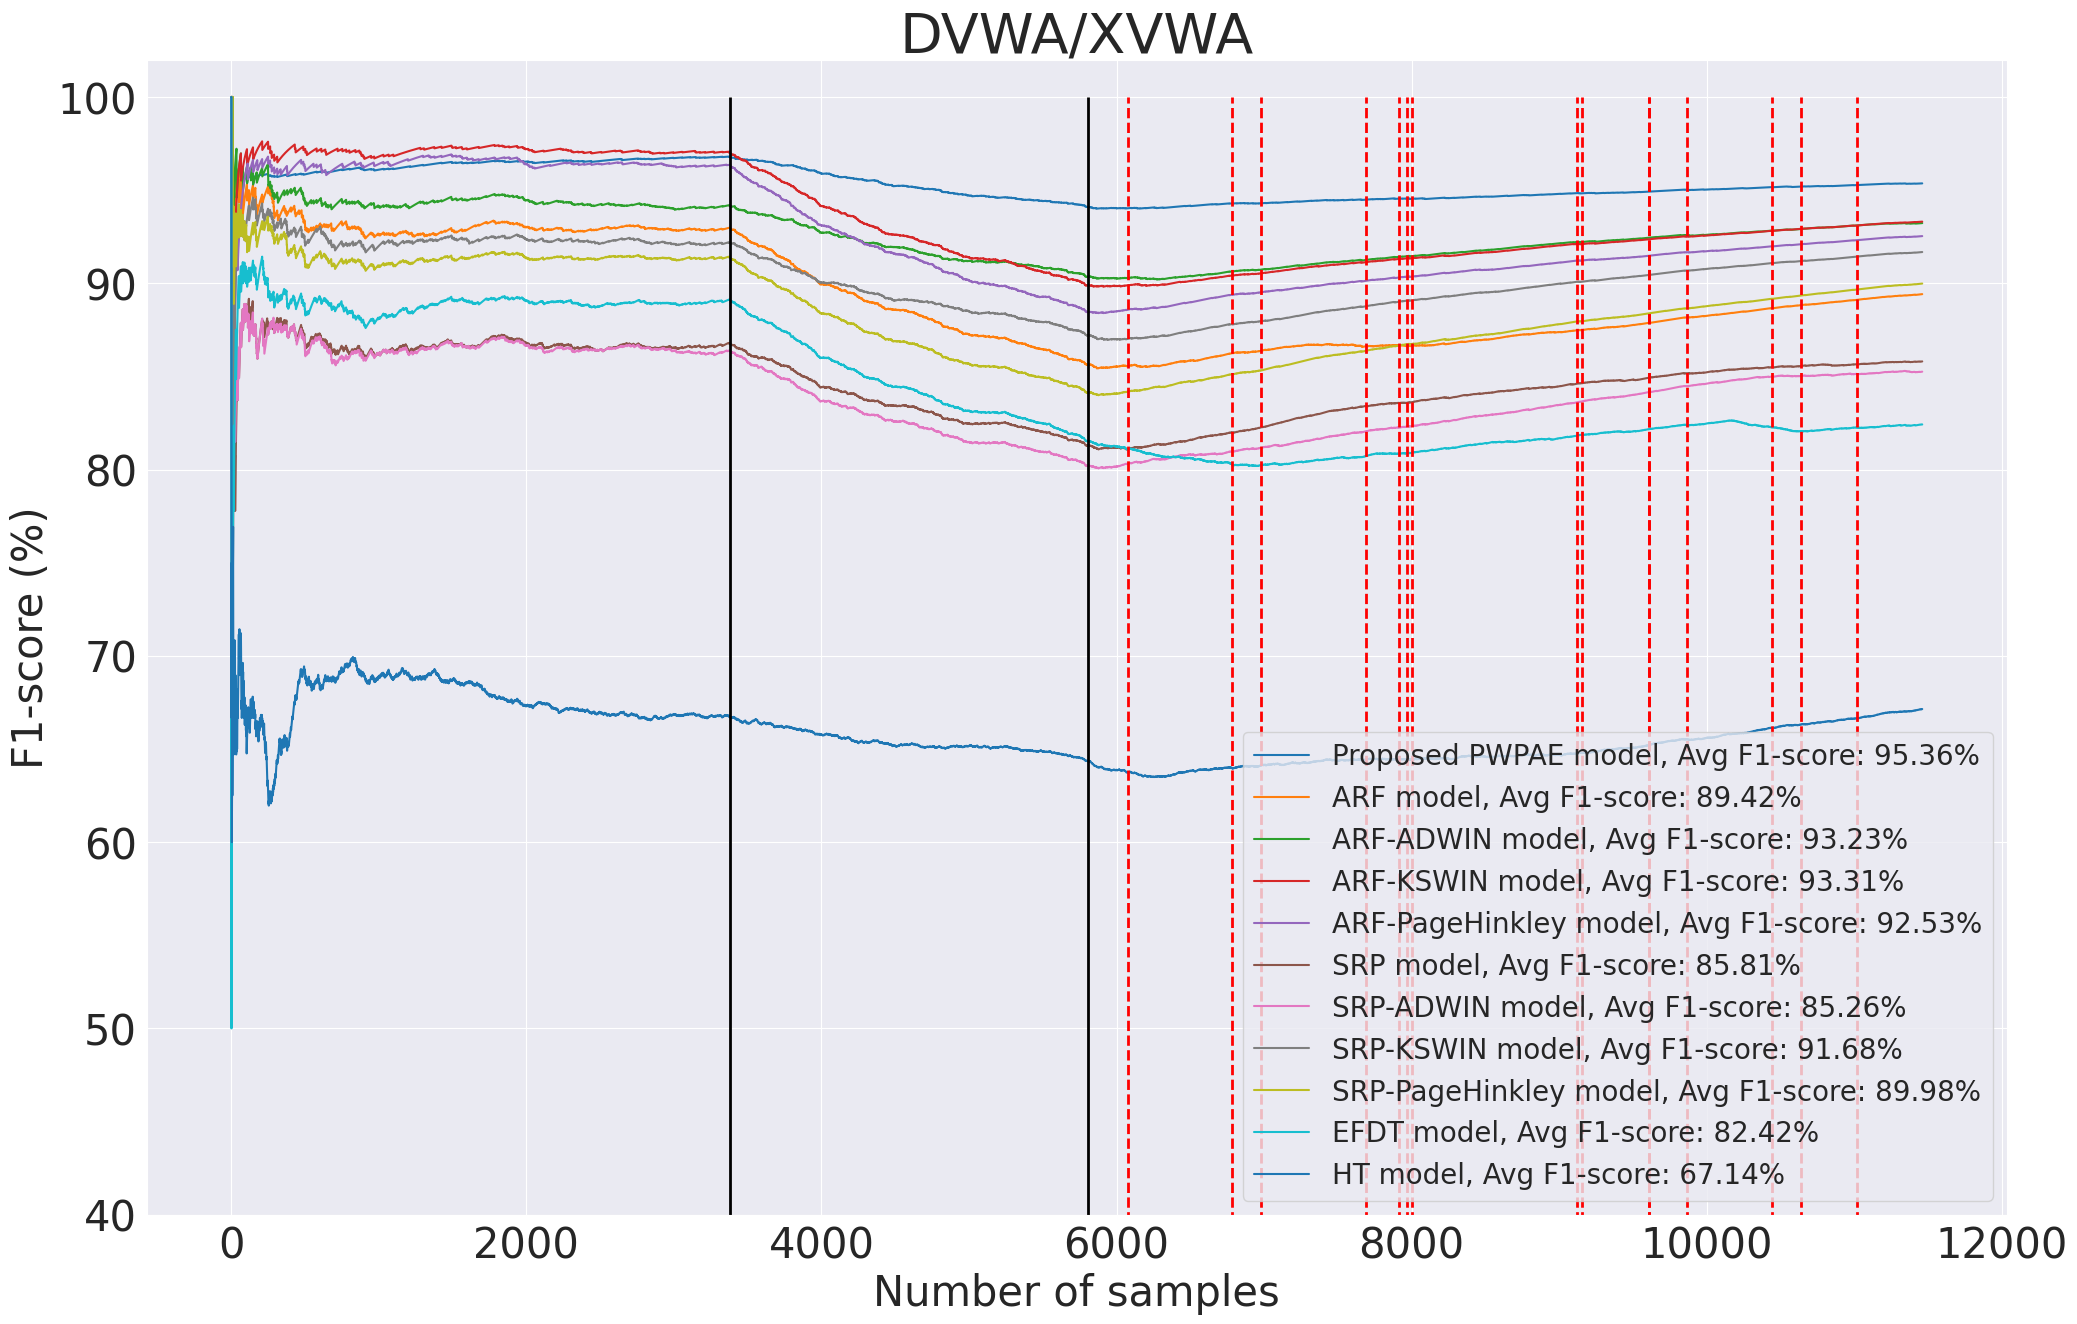

In [42]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,label=name+', Avg F1-score: %.2f%%'%(m[-1]))
plt.plot(t,m10,label=name10+', Avg F1-score: %.2f%%'%(m10[-1]))
plt.plot(t,m1,label=name1+', Avg F1-score: %.2f%%'%(m1[-1]))
plt.plot(t,m2,label=name2+', Avg F1-score: %.2f%%'%(m2[-1]))
plt.plot(t,m3,label=name3+', Avg F1-score: %.2f%%'%(m3[-1]))
plt.plot(t,m40,label=name40+', Avg F1-score: %.2f%%'%(m40[-1]))
plt.plot(t,m4,label=name4+', Avg F1-score: %.2f%%'%(m4[-1]))
plt.plot(t,m5,label=name5+', Avg F1-score: %.2f%%'%(m5[-1]))
plt.plot(t,m6,label=name6+', Avg F1-score: %.2f%%'%(m6[-1]))
plt.plot(t,m7,label=name7+', Avg F1-score: %.2f%%'%(m7[-1]))
plt.plot(t,m8,label=name8+', Avg F1-score: %.2f%%'%(m8[-1]))
# plt.plot(t,m9,label=name9+', Avg F1-score: %.2f%%'%(m9[-1]))

# Draw the drift points/time
# dr = [0,9900,12600, 14200,15800,18800,21600]
for i in range(len(dr)):
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=2, linestyles = "dashed")

plt.vlines(point, 0, 100, colors="black", linewidth=2)
plt.vlines(point1, 0, 100, colors="black", linewidth=2)
        
plt.legend(loc='lower right', fontsize=20)
plt.ylim(40, 102)
plt.title('DVWA/XVWA', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('F1-score (%)')
plt.savefig('adaptive.png')

# Тестирование

In [ ]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "Test PWPAE model"
t, m, dr = pwpae.predict_test(X_test2, y_test2)
acc_fig(t, m, name, dr) # Draw the figure of how the real-time accuracy changes with the number of samples
print(dr)

In [ ]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "Test PWPAE model"
t, m, dr = pwpae.partial_fit(X_test2, y_test2)
acc_fig(t, m, name, dr) # Draw the figure of how the real-time accuracy changes with the number of samples
print(dr)

In [ ]:
_, X_test, _, y_test = prepare_dataset(SOURCE_DATASET_FILENAME, train_size=0, test_size=1)

In [ ]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "Proposed and test PWPAE model full"
t, m, dr = pwpae.predict_test(X_test, y_test)
acc_fig(t, m, name, dr) # Draw the figure of how the real-time accuracy changes with the number of samples
print(dr)

In [ ]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "Proposed and test PWPAE model full"
t, m, dr = pwpae.partial_fit(X_test, y_test)
acc_fig(t, m, name, dr) # Draw the figure of how the real-time accuracy changes with the number of samples
print(dr)

In [ ]:
df.columns